# Time Augumentation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# pd.options.plotting.backend = "plotly"

from datetime import datetime, timedelta
from pathlib import Path

import tensorflow as tf
print(tf.__version__)

from tsa_aug import *

2.3.1


# DataFrame 

In [2]:
# DATA_PATH = Path("../DATA/denso/20200601/2020-05-07_124628_r4.csv")
DATA_PATH = Path("./2020-05-07_124628_r4.csv")

def read_data(path):
    df = pd.read_csv(str(path))
    df["Time"] = pd.to_datetime( datetime(2020,1,1,0,0) + pd.to_timedelta(df["Time"], unit="s") )
    df.set_index("Time", inplace=True)
    return df

def select_data(df):
    df_data = df.filter(regex="^Option0(0|1|2)_(x|y|z)$").copy()
    return df_data

def select_target(df):
    df_targets = df[["element_work"]].copy()
    return df_targets

def select_df_by_range(df, start_time, end_time):
    return df[start_time:end_time]

def draw_graph(xs, ys=None, figsize=None):
    if ys is None:
        if figsize is None:
            figsize=(18,2)
        plt.figure(figsize=figsize);
        if type(xs) is pd.DataFrame:
            xs = xs.values
        plt.plot(xs);
    else:
        if figsize is None:
            figsize=(18,4)
        fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=figsize)
        if type(xs) is pd.DataFrame:
            xs = xs.values
        if type(ys) is pd.DataFrame:
            ys = ys.values
        ax1.plot(xs)
        ax2.plot(ys)

def set_random_seed(seed=43):
    import tensorflow as tf
    import random
    import os
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHseed"] = str(seed)

In [3]:
df = read_data(DATA_PATH)
print(df.shape)

df_data = select_data(df)
df_targets = select_target(df)
data_column_names = list(df_data.columns)

(56021, 31)


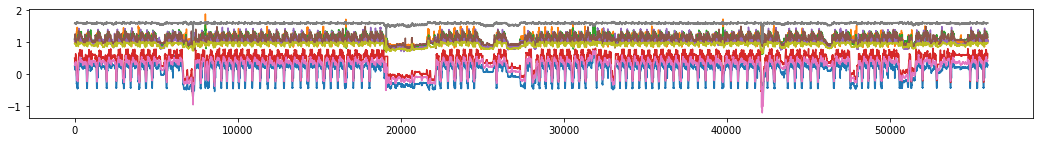

In [4]:
draw_graph(df_data)

## sampling rate

In [5]:
# 1コマの時間(ms)
data_sampling_period = df_data.index.to_series().diff().mean().value/1e6
print(f"data_sampling_period = {data_sampling_period}")

# fps
data_sampling_rate = 1e9/df_data.index.to_series().diff().mean().value
print(f"data_sampling_rate = {data_sampling_rate}")

RESAMPLE_PEDIOD = 200
print(data_sampling_period, RESAMPLE_PEDIOD)

data_sampling_period = 33.763769
data_sampling_rate = 29.617546548194902
33.763769 200


# 1周期分の時系列データのサンプリング

## candidate #1

(445, 9) (445, 1)


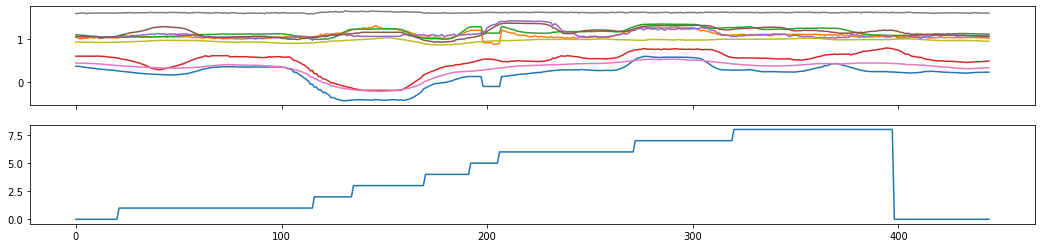

In [6]:
# START_TIME = "2020-01-01 00:05:12 5000"
CYCLE_START_TIME1 = datetime(2020, 1, 1, 0, 6, 20, 0)
# END_TIME = "2020-01-01 00:05:30"
CYCLE_END_TIME1 = datetime(2020, 1, 1, 0, 6, 35, 0)


df_data_sample1 = select_df_by_range(df_data, CYCLE_START_TIME1, CYCLE_END_TIME1)
df_targets_sample1 = select_df_by_range(df_targets, CYCLE_START_TIME1, CYCLE_END_TIME1)
print(df_data_sample1.shape, df_targets_sample1.shape)

draw_graph(df_data_sample1, df_targets_sample1)

## candidate #2

In [7]:
CYCLE_START_TIME2 = datetime(2020, 1, 1, 0, 23, 51, 0)
# END_TIME = "2020-01-01 00:05:30"
CYCLE_END_TIME2 = datetime(2020, 1, 1, 0, 24, 1, 950000)


df_data_sample2 = select_df_by_range(df_data, CYCLE_START_TIME2, CYCLE_END_TIME2)
df_targets_sample2 = select_df_by_range(df_targets, CYCLE_START_TIME2, CYCLE_END_TIME2)
print(df_targets.value_counts())
print(df_data_sample2.shape, df_targets_sample2.shape)

element_work
1               11054
2                8018
8                7996
0                7120
6                7098
4                5310
3                3978
7                3834
5                1613
dtype: int64
(322, 9) (322, 1)


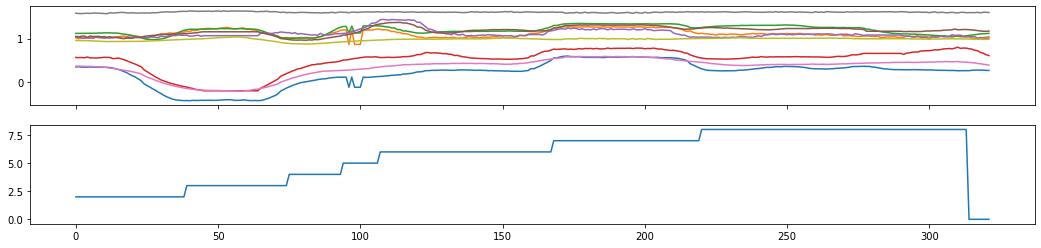

In [8]:
draw_graph(df_data_sample2, df_targets_sample2)

## candidate #3

(470, 9) (470, 1)


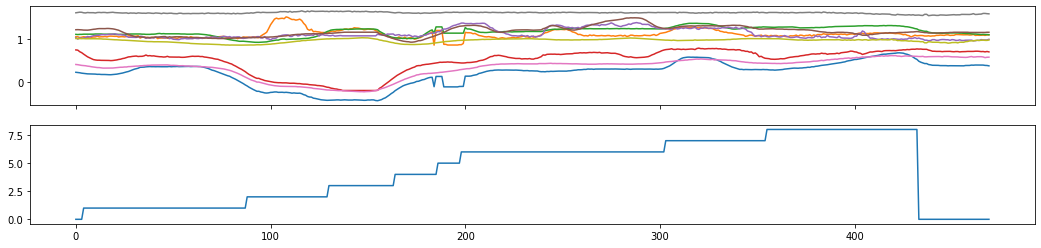

In [9]:
CYCLE_START_TIME3 = datetime(2020, 1, 1, 0, 17, 30, 600000)
# END_TIME = "2020-01-01 00:05:30"
CYCLE_END_TIME3 = datetime(2020, 1, 1, 0, 17, 46, 500000)


df_data_sample3 = select_df_by_range(df_data, CYCLE_START_TIME3, CYCLE_END_TIME3)
df_targets_sample3 = select_df_by_range(df_targets, CYCLE_START_TIME3, CYCLE_END_TIME3)
print(df_data_sample3.shape, df_targets_sample3.shape)

draw_graph(df_data_sample3, df_targets_sample3)

## candidate #4

(4432, 9) (4432, 1)


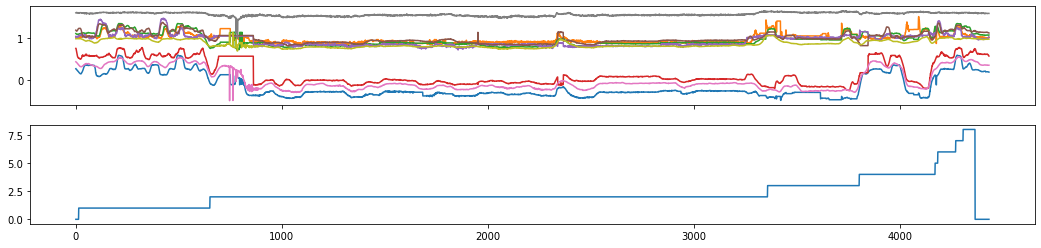

In [10]:
CYCLE_START_TIME4 = datetime(2020, 1, 1, 0, 10, 18, 650000)
# END_TIME = "2020-01-01 00:05:30"
CYCLE_END_TIME4 = datetime(2020, 1, 1, 0, 12, 47, 500000)


df_data_sample4 = select_df_by_range(df_data, CYCLE_START_TIME4, CYCLE_END_TIME4)
df_targets_sample4 = select_df_by_range(df_targets, CYCLE_START_TIME4, CYCLE_END_TIME4)
print(df_data_sample4.shape, df_targets_sample4.shape)


draw_graph(df_data_sample4, df_targets_sample4)

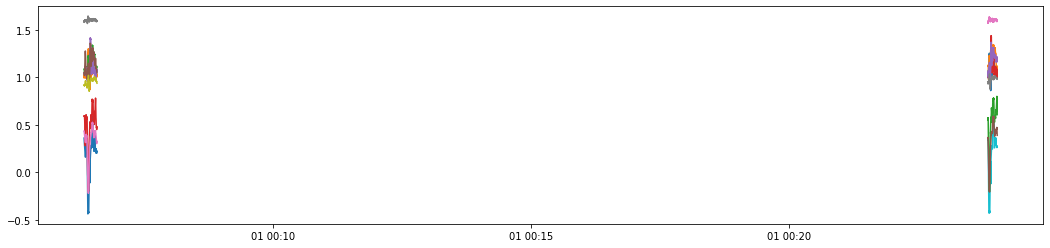

In [11]:
plt.figure(figsize=(18,4))
plt.plot(df_data_sample1)
plt.plot(df_data_sample2);
# plt.plot(df_data_sample3);
# plt.plot(df_data_sample4);

# Data Augument

In [12]:
RANDOM_SEED = 101
set_random_seed(RANDOM_SEED)

## repeat transform

In [13]:
def transoform_n_times_Xy(xs, ys, fx, fy, loops):
    xss, yss = [], []
    for param in loops:
        xs_new = fx(xs, param)
        ys_new = fy(ys, param)
        xss.append(xs_new)
        yss.append(ys_new)
    return np.concatenate(xss, axis=0), np.concatenate(yss, axis=0)

def stretchs_n_times_Xy(xs, ys, loops):
    xss, yss = [], []
    for i in loops:
        xs_new = stretch(xs, i)
        ys_new = stretch(ys, i, kind="nearest")
        xss.append(xs_new)
        yss.append(ys_new)
    return np.concatenate(xss, axis=0), np.concatenate(yss, axis=0)

def partial_stretches_n_times_Xy(xs, ys, rep_stretches):
    xss, yss = [], []
    for stretches in rep_stretches:
#         print(stretches)
        xs_new = partial_time_stretch(xs, stretches)
        ys_new = partial_time_stretch(ys, stretches, kind="nearest")
        xss.append(xs_new)
        yss.append(ys_new)
    return np.concatenate(xss, axis=0), np.concatenate(yss, axis=0)

def time_warps_n_times_Xy(xs, ys, n_times):
    xss, yss = [], []
    for _ in range(n_times):
        xs_new, ys_new = time_warp_Xy(xs, ys, n_knots=5)
        xss.append(xs_new)
        yss.append(ys_new)
    return np.concatenate(xss, axis=0), np.concatenate(yss, axis=0)

def merge_data(xss):
    return np.concatenate(xss, axis=0)

In [14]:
rep_stretches = []
for s in np.arange(1, 3.1, 0.1):
    for d in np.arange(0.1, 0.5, 0.1):
        for x in np.arange(0, 1.1, d):
            rep_stretches.append([[x, x+d, s]])

len(rep_stretches)

504

(261471, 9) (261471, 1) (189153, 9) (189153, 1) (189153, 9) (189153, 1)
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0}


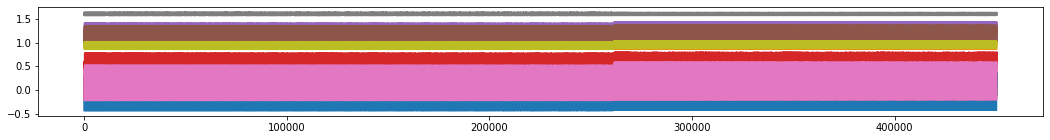

In [15]:
X1_, y1_ = partial_stretches_n_times_Xy(df_data_sample1.values, df_targets_sample1.values, rep_stretches=rep_stretches)
X2_, y2_ = partial_stretches_n_times_Xy(df_data_sample2.values, df_targets_sample2.values, rep_stretches=rep_stretches)
X3_, y3_ = partial_stretches_n_times_Xy(df_data_sample2.values, df_targets_sample2.values, rep_stretches=rep_stretches)

print(X1_.shape, y1_.shape, X2_.shape, y2_.shape, X3_.shape, y3_.shape)


X1, y1 = time_warps_n_times_Xy(X1_, y1_, n_times=10)
X2, y2 = time_warps_n_times_Xy(X2_, y2_, n_times=10)
# X3, y3 = time_warps_n_times_Xy(X3_, y3_, n_times=10)

X_ = merge_data([X1_, X2_])
y_ = merge_data([y1_, y2_])
 
X_stretched = jitter(X_, sigma=0.005)
y_stretched = y_

draw_graph(X_)

print(set(y_stretched.flatten().tolist()))

# 前処理 (np)
```
# def clipping_data(xs):
#     c_min, c_max = np.percentile(xs, [0.5, 99.5], axis=0)
#     return np.clip(xs, c_min, c_max)
```

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


def resample_data(xs):
    return resampling(xs, src_period=data_sampling_period, dst_period=RESAMPLE_PEDIOD, kind="linear")

def resample_targets(xs):
    return resampling(xs, src_period=data_sampling_period, dst_period=RESAMPLE_PEDIOD, kind="nearest")

def preprocess(xs, pipes):
    for p in pipes:
        xs = p(xs.copy())
    return xs

def clipping_data(xs):
    MIN_PERC, MAX_PERC = 2.5, 97.5
    c_min, c_max = np.percentile(xs, [MIN_PERC, MAX_PERC], axis=0)
    return np.clip(xs, c_min, c_max)

# TODO
sc = StandardScaler()
sc.fit(X_stretched)
def scaling_data(xs):
    global sc
    return sc.transform(xs)

ohe = OneHotEncoder(sparse=False)
ohe.fit(y_stretched)
def ohe_targets(xs):
    xs = xs.reshape(-1, 1)
    return ohe.transform(xs).astype(dtype="int32")

## Training Data

In [17]:
X_train = preprocess(X_stretched, [resample_data, clipping_data, scaling_data])
y_train = preprocess(y_stretched, [resample_targets, ohe_targets])

print(X_train.shape,  y_train.shape)
print(X_train.mean(axis=0))

(76074, 9) (76074, 9)
[-6.23036532e-05  1.73902023e-02  1.56787739e-03 -1.72902944e-04
 -1.73002144e-03  4.41012533e-03  6.07775050e-04  1.39459930e-03
  1.91900642e-03]


In [18]:
pd.DataFrame(y_train).value_counts()

0  1  2  3  4  5  6  7  8
0  0  0  0  0  0  0  0  1    17065
                  1  0  0    12606
                  0  1  0     9944
   1  0  0  0  0  0  0  0     9430
1  0  0  0  0  0  0  0  0     7393
0  0  0  1  0  0  0  0  0     7048
      1  0  0  0  0  0  0     5849
      0  0  1  0  0  0  0     4079
            0  1  0  0  0     2660
dtype: int64

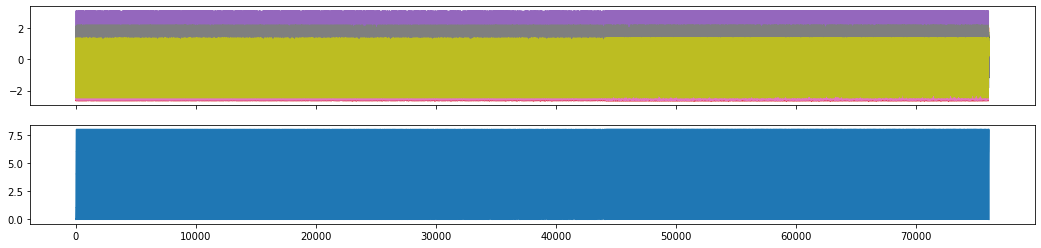

In [19]:
draw_graph(X_train, y_train.argmax(axis=1))

## Validation Data

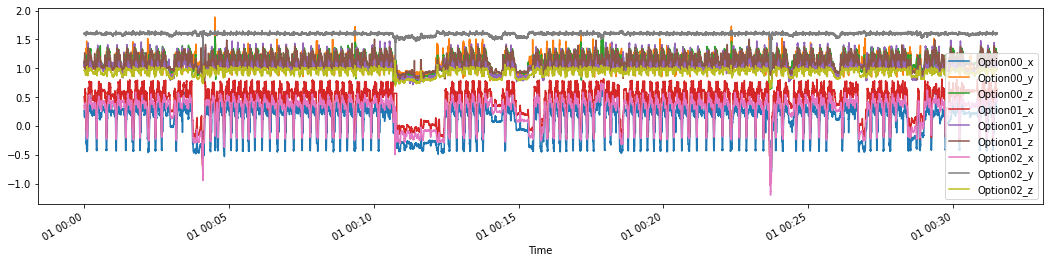

In [20]:
df_data.plot(figsize=(18,4));

In [21]:
# ohe_targets(resample_targets(df_targets_valid.values))

In [22]:
VALID_START_TIME = datetime(2020, 1, 1, 0, 5, 0)
VALID_END_TIME =   datetime(2020, 1, 1, 0, 10, 0)

df_data_valid = (
    read_data(DATA_PATH)
    .pipe(select_data)
#     .pipe(select_df_by_range, VALID_START_TIME, VALID_END_TIME)
    )
df_targets_valid = (read_data(DATA_PATH)
    .pipe(select_target)
#     .pipe(select_df_by_range, VALID_START_TIME, VALID_END_TIME)
    )
print(df_data_valid.shape, df_targets_valid.shape)

X_valid = preprocess(df_data_valid.values, [resample_data, clipping_data,  scaling_data])
y_valid = preprocess(df_targets_valid.values, [resample_targets, ohe_targets])
print(X_valid.shape, y_valid.shape)
print(X_valid.mean(axis=0))

(56021, 9) (56021, 1)
(9458, 9) (9458, 9)
[-0.258242   -0.30435899 -0.48332016 -0.23056039 -0.47760099 -0.45892222
 -0.30507752 -0.60701907 -0.78832388]


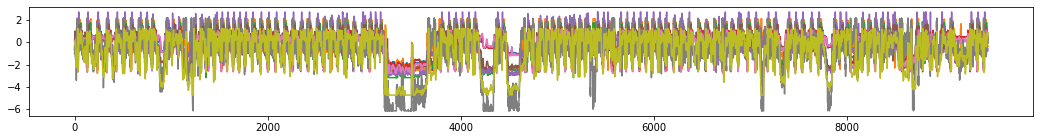

In [23]:
draw_graph(X_valid)

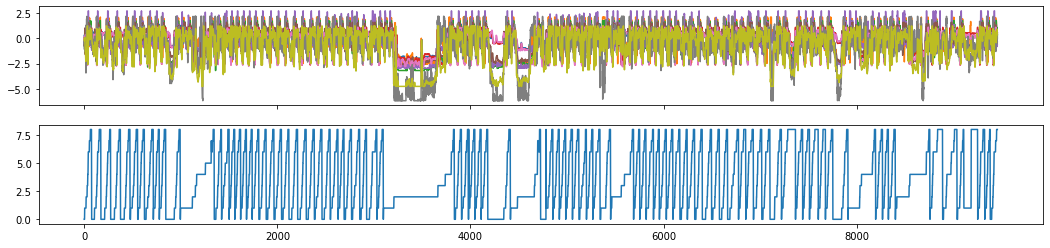

In [24]:
draw_graph(X_valid, y_valid.argmax(axis=1))

# Time Series Generator

In [25]:
set_random_seed(RANDOM_SEED)

In [26]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [27]:
T = 100 # 50
D = 9

In [28]:
BATCH_SIZE = 256
generator_train = TimeseriesGenerator(X_train, y_train, length=T, batch_size=BATCH_SIZE, shuffle=True)
generator_valid = TimeseriesGenerator(X_valid, y_valid, length=T, batch_size=BATCH_SIZE, shuffle=False)

# RNN

In [29]:
from tensorflow.keras.layers import Dense, SimpleRNN, Input, LSTM, GRU, Flatten, Bidirectional, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
i = Input(shape=(T,D)) # (T, D)
x= Bidirectional(LSTM(T, activation="tanh", use_bias=True, name="lstm", 
        return_sequences=True,
        recurrent_activation='sigmoid',
        kernel_initializer='glorot_normal',
        dropout = 0.5,
        recurrent_initializer='orthogonal'
        ), merge_mode="concat")(i)                  
x= Bidirectional(LSTM(T//2, activation="tanh", use_bias=True, name="lstm", 
        return_sequences=True,
        recurrent_activation='sigmoid',
        kernel_initializer='glorot_normal',
        dropout = 0.5,
        recurrent_initializer='orthogonal'
        ), merge_mode="concat")(x)
# x= Bidirectional(LSTM(T//4, activation="tanh", use_bias=True, name="lstm", 
#         return_sequences=True,
#         recurrent_activation='sigmoid',
#         kernel_initializer='glorot_normal',
#         dropout = 0.5,
#         recurrent_initializer='orthogonal'
#         ), merge_mode="concat")(x)   
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(9, activation="sigmoid", kernel_initializer="glorot_normal")(x)
model = Model(i, x)

In [31]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 9)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 200)          88000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 100)          100400    
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 9)                 90009     
Total params: 278,409
Trainable params: 278,409
Non-trainable params: 0
________________________________________________

In [32]:
# model.compile(loss="mse", optimizer=Adam(lr=0.001))
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"])

In [33]:
es = EarlyStopping(patience=10, verbose=2, monitor="val_loss")
cp = ModelCheckpoint(filepath="saved_model_10_01/", monitor="val_acc", save_best_only=True, verbose=1)
r = model.fit(generator_train, epochs=400, validation_data=generator_valid, callbacks=[es, cp], verbose=2)

Epoch 1/400

Epoch 00001: val_acc improved from -inf to 0.62748, saving model to saved_model_10_01/
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model_10_01/assets
297/297 - 24s - loss: 0.3286 - acc: 0.8697 - val_loss: 2.7664 - val_acc: 0.6275
Epoch 2/400

Epoch 00002: val_acc did not improve from 0.62748
297/297 - 9s - loss: 0.1563 - acc: 0.9366 - val_loss: 2.4904 - val_acc: 0.6184
Epoch 3/400

Epoch 00003: val_acc improved from 0.62748 to 0.65356, saving model to saved_model_10_01/
INFO:tensorflow:Assets written to: saved_model_10_01/assets
297/297 - 23s - loss: 0.1323 - acc: 0.9463 - val_loss: 2.7708 - val_acc: 0.6536
Epoch 4/400

Epoch 00004: val_acc did not improve from 0.65356
297/297 - 9s - loss: 0.1225 - acc: 0.9493 - val_loss: 2.8681 - val_acc: 0.6072

# Evaluate

In [34]:
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# import seaborn as sns

In [35]:
model = load_model("saved_model_10_01")

In [36]:
generator_valid.end_index

9457

In [37]:
ys_pred = []
ys_true = []

for x, y in generator_valid:
    y_pred = model.predict(x)
    ys_pred.append(y_pred)
    ys_true.append(y)

ys_prob = np.concatenate(ys_pred, axis=0).max(axis=1)
ys_pred = np.concatenate(ys_pred, axis=0).argmax(axis=1)
ys_true = np.concatenate(ys_true, axis=0).argmax(axis=1)

ys_pred.shape, ys_true.shape, ys_prob.shape

((9358,), (9358,), (9358,))

In [38]:
model.evaluate(generator_valid)

37/37 [==============================] - 0s 11ms/step - loss: 2.7264 - acc: 0.6593


[2.7263975143432617, 0.6593289375305176]

In [39]:
# print(classification_report(ys_true, ys_pred))
accuracy_score(ys_true, ys_pred)

0.6593289164351357

In [40]:
model.evaluate(generator_train)

297/297 [==============================] - 4s 13ms/step - loss: 0.0507 - acc: 0.9785


[0.05067049339413643, 0.978482723236084]

In [41]:
# model.evaluate(generator_all)

In [42]:
print(classification_report(ys_true, ys_pred))
print("precision => 真値 x のうち、x と予測した割合(行)")
print("recall => x と予測したうち、真値が x であった割合(列)")

              precision    recall  f1-score   support

           0       0.39      0.36      0.38      1176
           1       0.59      0.52      0.55      1854
           2       0.66      0.69      0.67      1344
           3       0.72      0.83      0.77       658
           4       0.70      0.58      0.63       898
           5       0.46      0.60      0.52       268
           6       0.88      0.83      0.85      1192
           7       0.62      0.95      0.75       635
           8       0.82      0.78      0.80      1333

    accuracy                           0.66      9358
   macro avg       0.65      0.68      0.66      9358
weighted avg       0.66      0.66      0.66      9358

precision => 真値 x のうち、x と予測した割合(行)
recall => x と予測したうち、真値が x であった割合(列)


In [43]:
# plt.figure(figsize=(8,6))
# sns.heatmap(confusion_matrix(ys_true, ys_pred), annot=True, fmt="g")

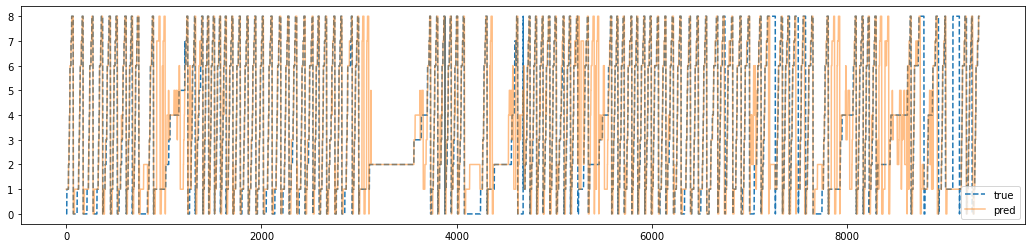

In [44]:
plt.figure(figsize=(18, 4))
plt.plot(ys_true, label="true",linestyle="--")
plt.plot(ys_pred, label="pred", alpha=0.5)
plt.legend(loc="lower right")

# 全体で予測

In [45]:
START_TIME = df_data.index[0]
END_TIME = df_data.index[-1]

RULE = "200ms"

def resampling(df, rule, func):
    return df.resample(rule=rule).agg(func)

X_all_ = (read_data(DATA_PATH)
     .pipe(select_data)
     .pipe(select_df_by_range, START_TIME, END_TIME)
     .pipe(resampling, RULE, "mean")
    ).values.astype(dtype="float32")
y_all_ = (read_data(DATA_PATH)
     .pipe(select_target)
     .pipe(select_df_by_range, START_TIME, END_TIME)
     .pipe(resampling, RULE, "ffill")
#      .pipe(fillna)
     .pipe(pd.get_dummies, columns=["element_work"], drop_first=False)
    ).values.astype(dtype="int32")

X_all_.shape, y_all_.shape

((9458, 9), (9458, 9))

In [46]:
X_all_.shape, y_all_.shape

((9458, 9), (9458, 9))

In [47]:
X_all = preprocess(X_all_, [scaling_data])
y_all = y_all_ #preprocess(y_all_, [astype_int32])

X_all.shape, y_all.shape

((9458, 9), (9458, 9))

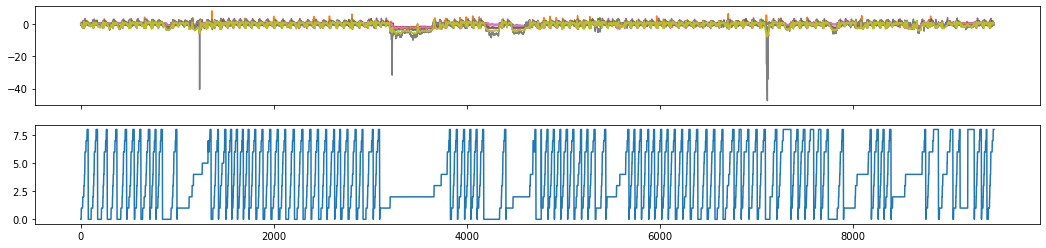

In [48]:
draw_graph(X_all, y_all.argmax(axis=1))

In [49]:
generator_all = TimeseriesGenerator(X_all, y_all, length=T, batch_size=4000, shuffle=False)

In [50]:
ys_pred = []
ys_true = []

for x, y in generator_all:
    y_pred = model.predict(x)
    ys_pred.append(y_pred)
    ys_true.append(y)

ys_prob = np.concatenate(ys_pred, axis=0).max(axis=1)
ys_pred = np.concatenate(ys_pred, axis=0).argmax(axis=1)
ys_true = np.concatenate(ys_true, axis=0).argmax(axis=1)

ys_pred.shape, ys_true.shape, ys_prob.shape

((9358,), (9358,), (9358,))

In [51]:
print(classification_report(ys_true, ys_pred))

              precision    recall  f1-score   support

           0       0.39      0.36      0.38      1166
           1       0.59      0.52      0.55      1844
           2       0.64      0.67      0.65      1340
           3       0.68      0.80      0.74       677
           4       0.68      0.55      0.61       902
           5       0.40      0.51      0.45       269
           6       0.85      0.80      0.83      1190
           7       0.60      0.94      0.73       635
           8       0.83      0.78      0.80      1335

    accuracy                           0.65      9358
   macro avg       0.63      0.66      0.64      9358
weighted avg       0.65      0.65      0.64      9358



In [52]:
# plt.figure(figsize=(8,6))
# sns.heatmap(confusion_matrix(ys_true, ys_pred), annot=True, fmt="g");
accuracy_score(ys_true, ys_pred)

0.645864500961744

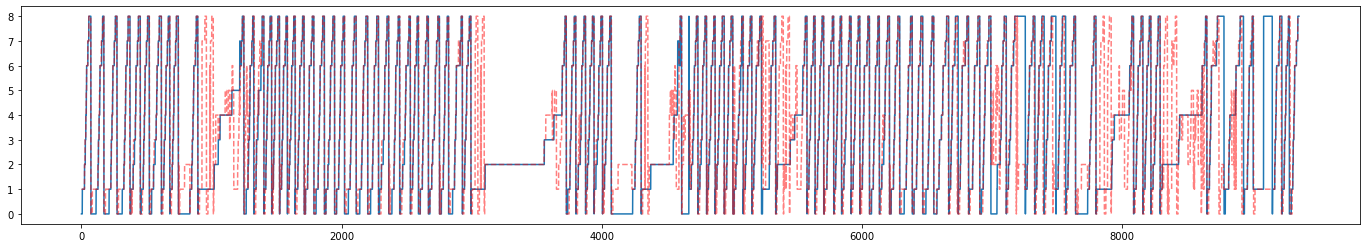

In [53]:
def plot_result(start=0, end=len(ys_pred)):
    cmap = plt.get_cmap("tab10") # ココがポイント
    fig, (ax1) = plt.subplots(1, 1, figsize=(24,4), sharex=True)
    ax1.plot(range(start,end), ys_true[start:end])
    ax1.plot(range(start,end), ys_pred[start:end], alpha=0.5, linestyle="--", color="red");
    
plot_result()

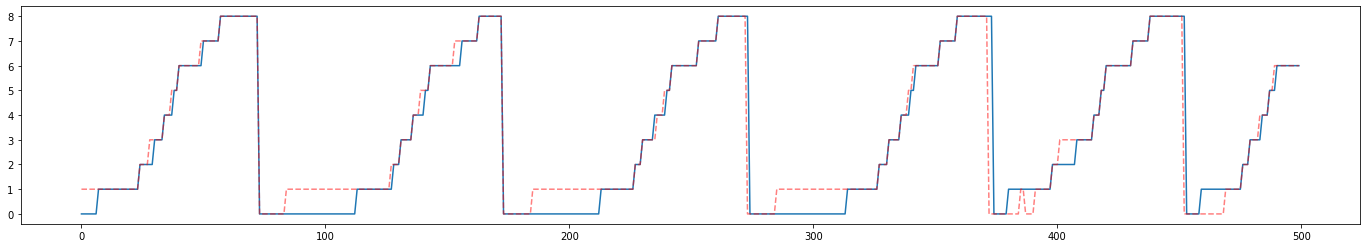

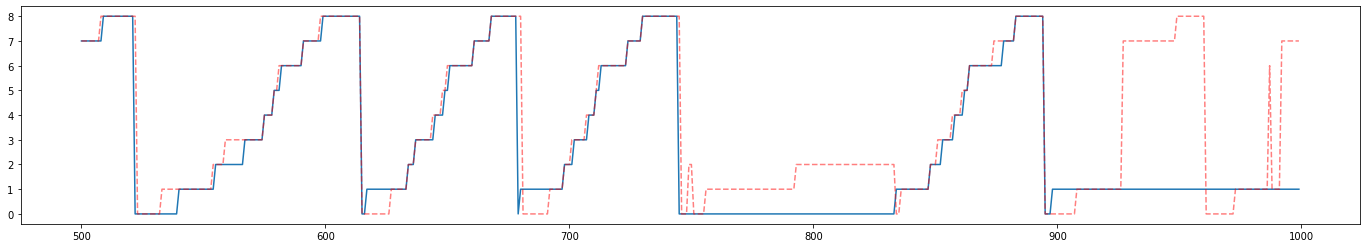

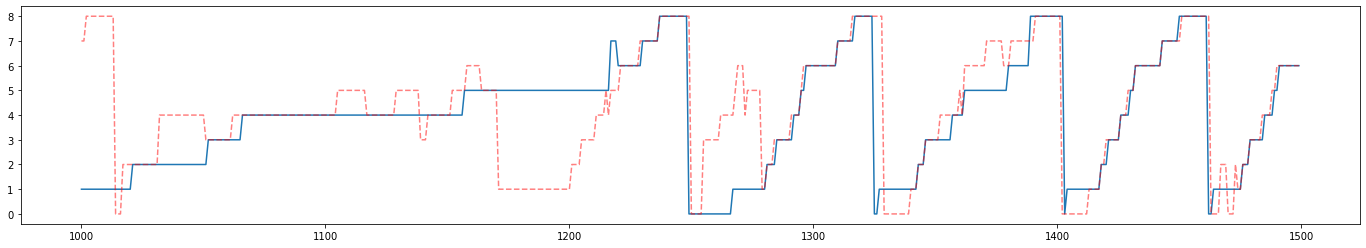

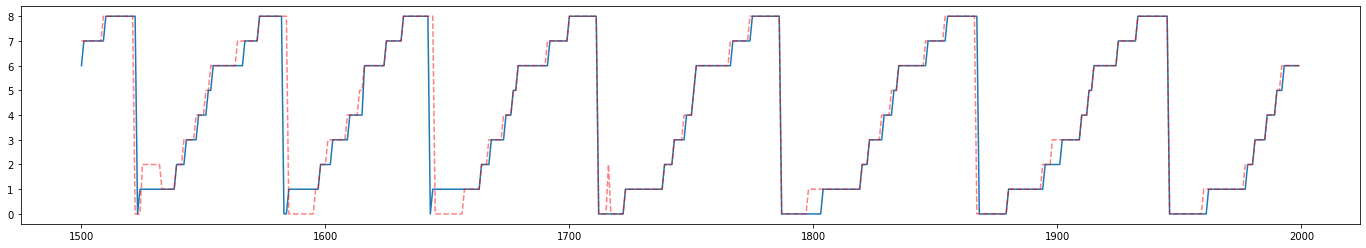

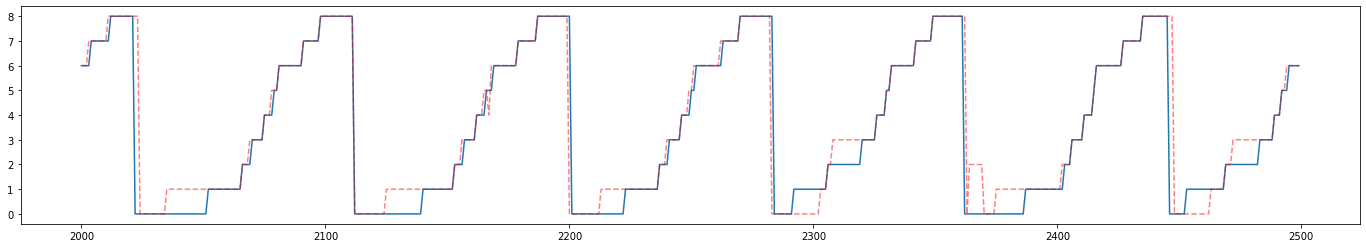

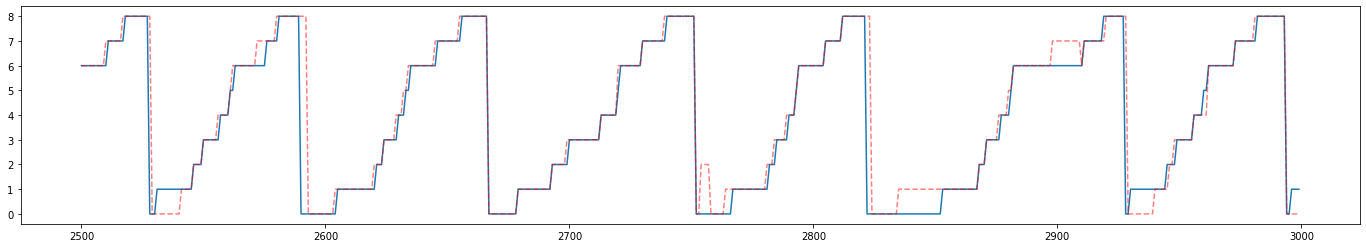

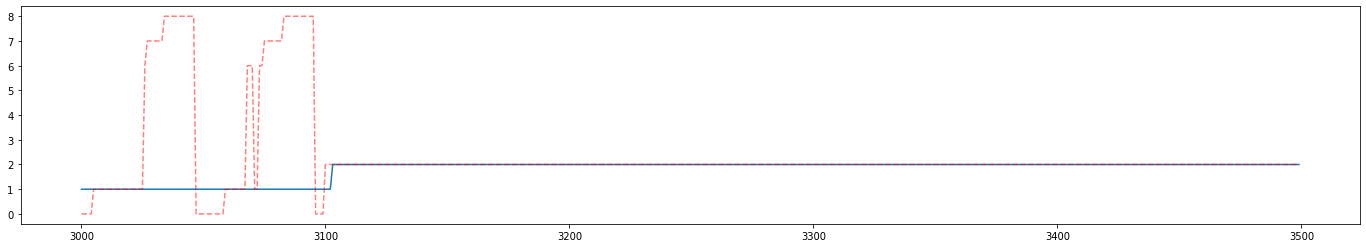

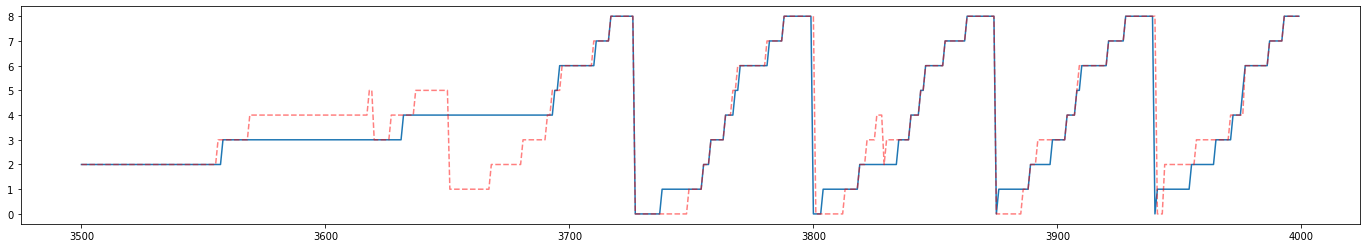

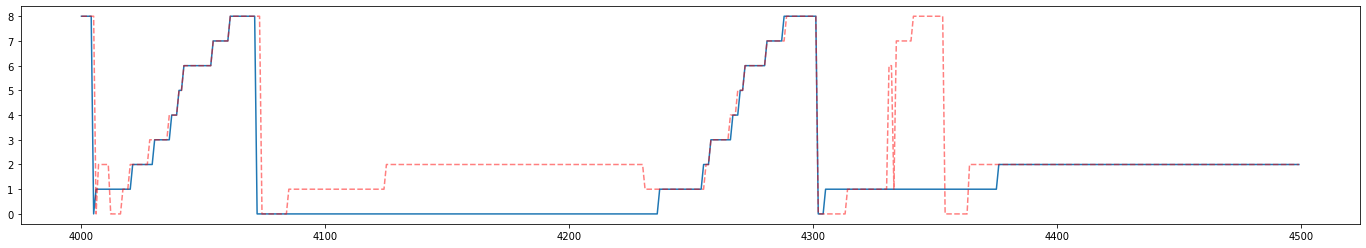

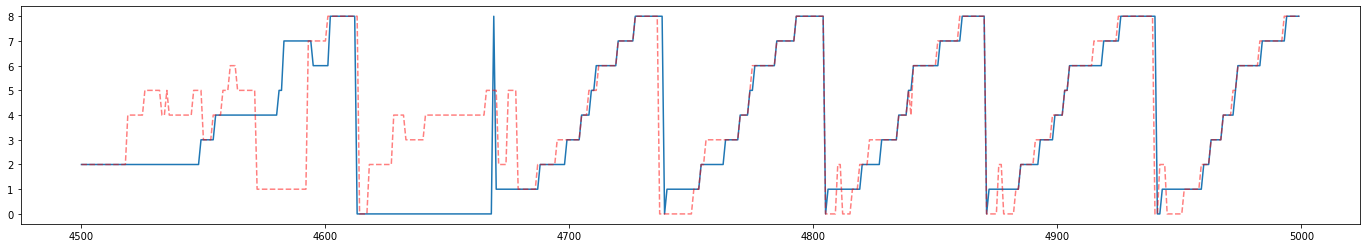

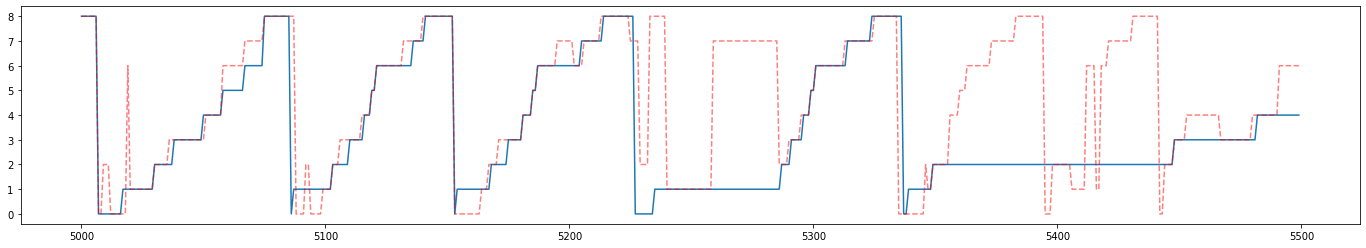

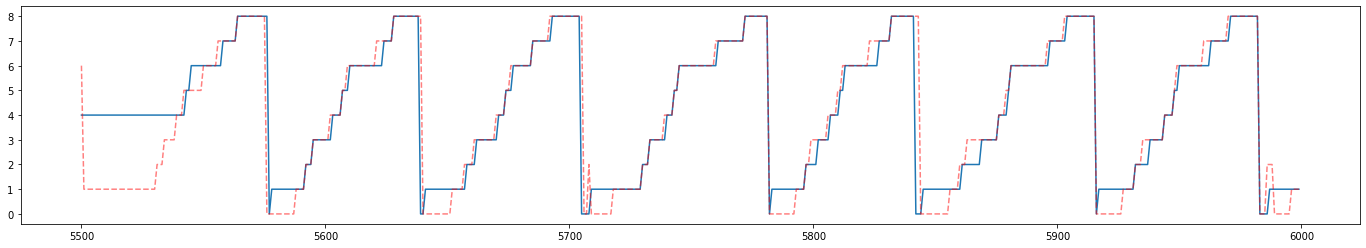

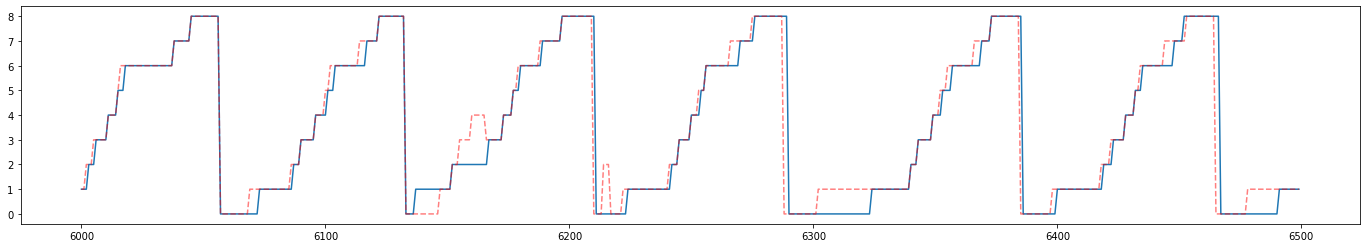

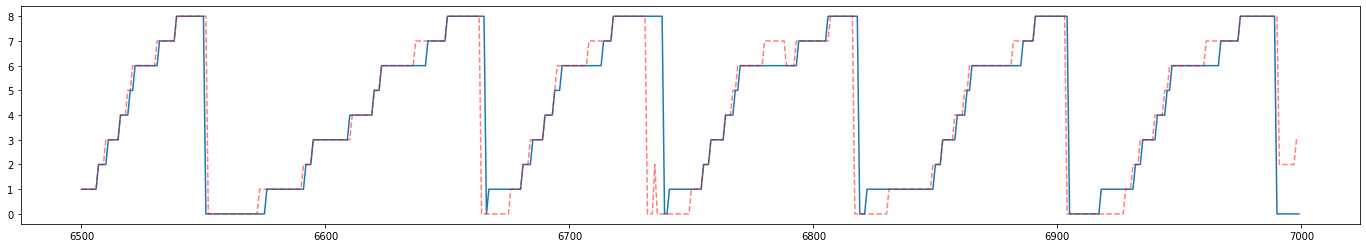

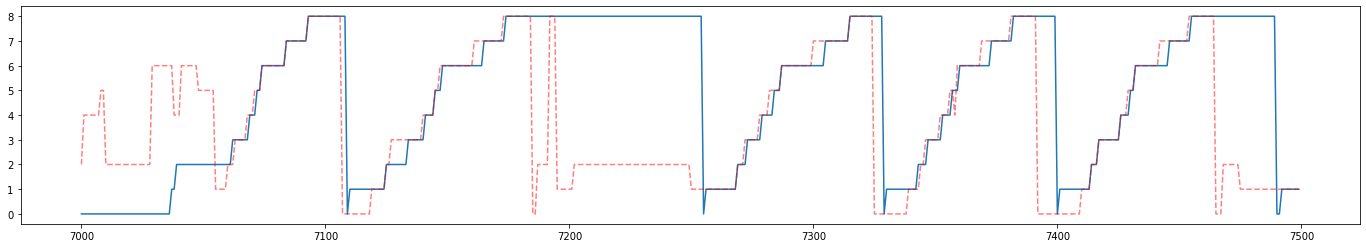

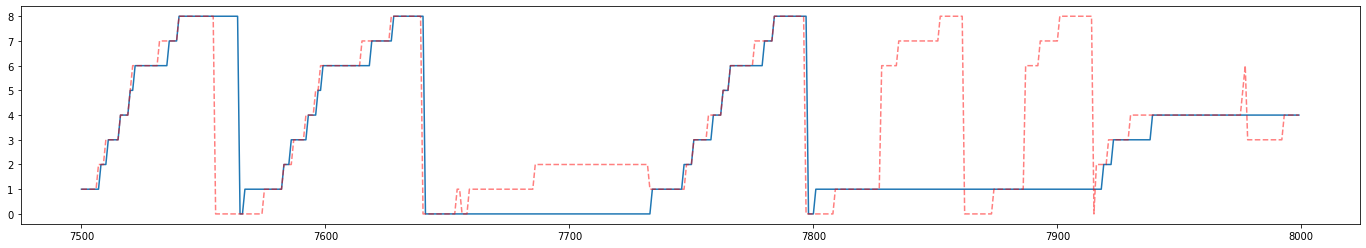

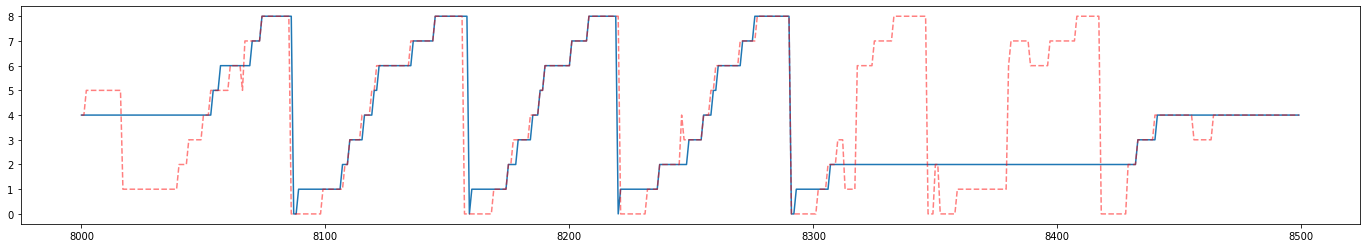

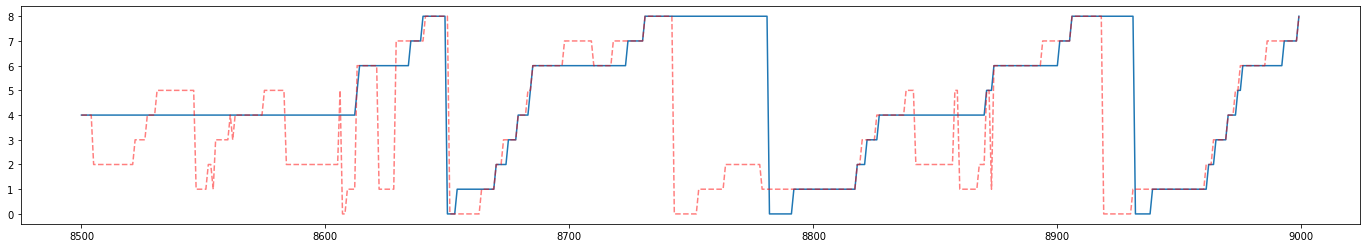

In [54]:
duration = 500
start, end = 0, duration
while True:
#     print(start, end)
    plot_result(start, end)
    start += duration
    end += duration
    if end>len(ys_pred):
        break

# Last